In [14]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import pickle
rng = np.random.default_rng(42)

## Q1. Use Approximate Bayesian Computation (ABC) to learn the hyperparameters of a Gaussian Process.
### This is a hard problem, so we are going to use a small dataset:

In [20]:
with open("data_ps6.pkl", "rb") as f:
    xs, ys = pickle.load(f)

### Define the matern 3/2 kernel, and draw from the priors over the two parameters of GP: xi and sigma^2
#### (adapted from Hogg code)

In [100]:
def mk(xs1, xs2, sigma_sq, xi):
    d = np.subtract.outer(xs1, xs2) #distances
    return sigma_sq * ((1+(np.sqrt(3))*d/xi) * np.exp(-np.sqrt(3*d*d)/xi))

def draw(pars, rng=rng): #flat priors
    sigma_sq = pars[0] + (pars[1] - pars[0]) * rng.uniform()
    xi = pars[2] + (pars[3] - pars[2]) * rng.uniform()
    return sigma_sq, xi

def simulate(xs, pars, rng=rng):
    sigma_sq, xi = draw(pars, rng=rng)
    var = mk(xs, xs, sigma_sq, xi)
    return sigma_sq, xi, rng.multivariate_normal(0. * xs, var) #K is truly a variance!

C:\Users\ajati\AppData\Local\Temp\ipykernel_10460\439360285.py:13: RuntimeWarning: covariance is not positive-semidefinite.
  return sigma_sq, xi, rng.multivariate_normal(0. * xs, var)


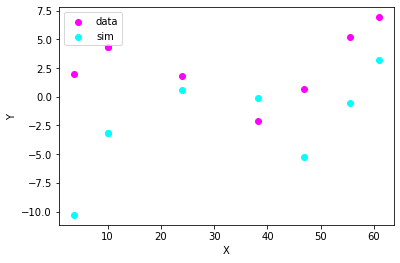

In [30]:
#run the simulation
prior_pars = np.array([10., 100., 1., 10.])
sigma_sq, xi, ysim = simulate(xs, prior_pars)

fig, ax = plt.subplots()
ax.scatter(xs, ys, marker = 'o', c = 'magenta', label = 'data')
ax.scatter(xs, ysim, marker = 'o', c = 'cyan', label = 'sim')
ax.legend()
ax.set_xlabel('X')
_=ax.set_ylabel('Y')

### So far, so good...so what?
### Now, run this simulation many many times and pick the simulations for which some criterion is satisfied

In [114]:
def ABC(xs, ys, pars, eps):
    #run the simulation 
    sigma_sq, xi, ysim = simulate(xs, pars)
    res = res_out(ys, ysim)
    accept = False
    if res < eps:
        accept = True
    return accept, sigma_sq, xi
    
def res_out(y, yhat): #compute the l2 norm, and average
    res = [(y[i]**2 + yhat[i]**2)**1/2 for i in range(len(y))]
    return np.mean(res)

def fullABC(xs, ys, pars, eps0, N): #start with a large epsilon eps0
    eps = eps0
    n = 0
    scale = 2 #a scaling factor
    num_accept = 0 #keep track of number of acceptances
    sigma_sq_list = []
    xi_list = []
    eps_list = []
    while n<N:
        if (n+1)%5000 == 0:
            print('{}-th iteration'.format(n))
        accept, sigma_sq, xi = ABC(xs, ys, pars, eps)
        if accept:
            eps/=2 #make the threshold even smaller if accepted
            #we want to make priors become more and more constrained. Choose the larger or smaller between two
                #options depending on limits
            p0, p1, p2, p3 = pars[0], pars[1], pars[2], pars[3]
            p0 = max(pars[0], xi-sigma_sq*scale)
            p1 = min(pars[1], xi+sigma_sq*scale)
            p2 = max(pars[2], xi-sigma_sq*scale)
            p3 = min(pars[3], xi+sigma_sq*scale)
            pars = np.array([p0, p1, p2, p3])
            num_accept += 1
        else: 
            eps*=1.05 #else, make threshold bigger
        n += 1
        sigma_sq_list.append(sigma_sq)
        xi_list.append(xi)
        eps_list.append(eps)
    return eps_list, sigma_sq_list, xi_list

C:\Users\ajati\AppData\Local\Temp\ipykernel_10460\4041756349.py:13: RuntimeWarning: covariance is not positive-semidefinite.
  return sigma_sq, xi, rng.multivariate_normal(0. * xs, var) #K is truly a variance!


4999-th iteration
9999-th iteration
14999-th iteration
19999-th iteration


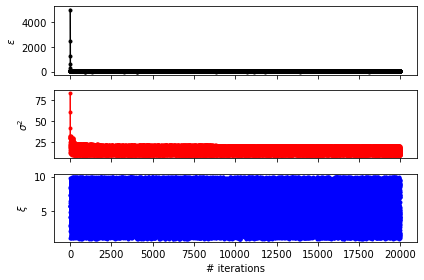

In [115]:
N = 20000
eps_list, sigma_sq_list, xi_list = fullABC(xs, ys, np.array([10., 100., 1., 10.]), 10000, N)
fig, [ax0, ax1, ax2] = plt.subplots(3, sharex = True)
ax2.set_xlabel('# iterations')
ax0.plot(np.arange(N), eps_list, 'k.-')
ax1.plot(np.arange(N), sigma_sq_list, 'r.-')
ax2.plot(np.arange(N), xi_list, 'b.-')
ax0.set_ylabel(r'$\epsilon$')
ax1.set_ylabel(r'$\sigma^{2}$')
ax2.set_ylabel(r'$\xi$')
plt.tight_layout()

## Q2. Revisit pset05 q1, and re-do the linear regression problem with a neural network.

In [118]:
tr_file  = "ap17_xpcont_train.pickle"
val_file = "ap17_xpcont_validation.pickle"

with open(tr_file, 'rb') as f1:
    data_tr = pickle.load(f1)

with open(val_file, 'rb') as f2:
    data_val = pickle.load(f2)
    
#TRAINING DATA:
Y_data_train = data_tr['labels'][:,0] #T_eff. Col vector of n = 4000
max_rp = np.max(data_tr['rp_coef'])
X_bp = data_tr['bp_coef']/max_rp
X_rp = data_tr['rp_coef']/max_rp
X_data_train = np.dstack((X_bp, X_rp)) #X_data has shape (4000, 55, 2)

#VALIDATION DATA:
Y_data_val = data_val['labels'][:,0] #T_eff. Col vector of n = 1000
max_rp = np.max(data_val['rp_coef'])
X_bp = data_val['bp_coef']/max_rp
X_rp = data_val['rp_coef']/max_rp
X_data_val = np.dstack((X_bp, X_rp)) #X_data has shape (1000, 55, 2)

In [170]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

nsamples, nx, ny = X_data_train.shape
print(nsamples, nx, ny)
d2_X_train = X_data_train.reshape((nsamples, nx*ny))
regr = MLPRegressor(random_state=1, max_iter=3000).fit(d2_X_train, Y_data_train)


4000 55 2


C:\Users\ajati\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (3000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [171]:
nsamples, nx, ny = X_data_val.shape
d2_X_val = X_data_val.reshape((nsamples, nx*ny))
regr.predict(d2_X_val)
regr.score(d2_X_val, Y_data_val)

0.523829312986848

C:\Users\ajati\AppData\Local\Temp\ipykernel_10460\528698252.py:8: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  SST = np.sum((Y[i] - np.mean(Y_hat))**2 for i in range(len(Y))) #total sum of squares


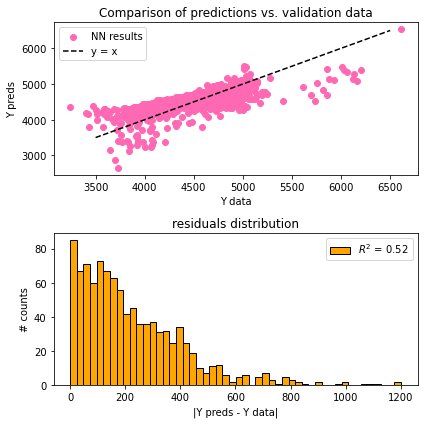

In [172]:
fig, [ax0, ax1] = plt.subplots(2, figsize = (6, 6))

Y = Y_data_val.flatten()
Y_hat = regr.predict(d2_X_val)

res = abs(Y-Y_hat) 
SSR = np.sum(res**2) #sum of squares of residuals
SST = np.sum((Y[i] - np.mean(Y_hat))**2 for i in range(len(Y))) #total sum of squares
R_sq = 1-SSR/SST

ax0.scatter(Y, Y_hat, marker = 'o', c = 'hotpink', label = 'NN results')
ax0.plot([3500, 6500], [3500, 6500], 'k--', label = 'y = x')
ax1.hist(res, bins = 50, color = "orange", ec="black", \
             label='$R^2$ = {}'.format(np.round(R_sq,2)))
ax1.legend()
ax1.set_ylabel('# counts')
ax1.set_xlabel('|Y preds - Y data|')

ax0.legend()
ax0.set_title('Comparison of predictions vs. validation data')
ax1.set_title('residuals distribution')
ax0.set_xlabel(r'Y data')
_=ax0.set_ylabel(r'Y preds')
plt.tight_layout()

### To me, it looks like the neural net performs worse than the regular linear regression. Note that optimization didn't converge, so there is definitely some improvement that could be done on the NN to get better scores.
### That $R^2$ value is terrible